In [15]:
#Import all functions
import pandas as pd
import dask.dataframe as dd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import binned_statistic as bnn
import seaborn as sns
import statsmodels.formula.api as smf
pd.set_option('display.float_format', '{:.2f}'.format,'display.max_rows', 5)

#### 1. Load Data

In [16]:
#Read all csv files in folder
df= dd.read_csv('*.csv').compute() 
#Read 'Revenue.txt' file
df_1=pd.read_fwf('Revenue.txt', colspecs=[[0,10],[10,14],[14,16]],\
                 header=None, names=["logrev", "rest_id", "time"]) 
#Merge two dataframes
df=pd.merge(df, df_1,  how='left', left_on=['rest_id','time'], right_on = ['rest_id','time']) 
df

,stars,score,rest_id,time,logrev
0,1.00,1.15,1,1,1.63
1,1.00,1.01,2,1,1.44
...,...,...,...,...,...
14998,5.00,5.00,1499,10,10.29
14999,0.50,0.73,1500,10,1.52


#### 2. Describe the data
##### (a) Number of restaurants, the mean, s.d., min and max revenue for each number of displayed stars

In [17]:
df.groupby('stars').logrev.describe() #Data clustered by number of displayed stars

,count,mean,std,min,25%,50%,75%,max
stars,,,,,,,,
0.00,1113.00,0.89,1.99,-5.90,-0.51,0.95,2.31,6.93
0.50,1155.00,1.53,2.12,-5.12,0.08,1.63,2.97,7.78
...,...,...,...,...,...,...,...,...
4.50,1215.00,8.38,2.12,1.93,6.99,8.40,9.84,14.98
5.00,1208.00,9.62,1.95,2.78,8.29,9.62,10.91,15.27


##### (b) Binned Scatter Plot Store Revenue against True Yelp Score
Bin size is 0.05, so there are 100 bins.

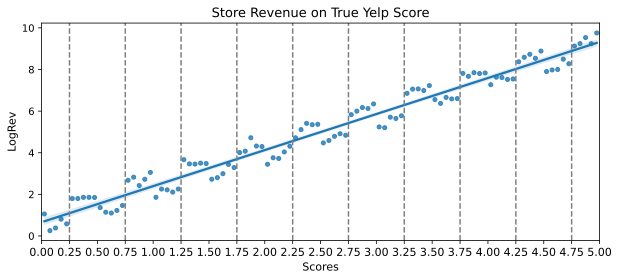

In [18]:
y, edge, ind = bnn(df.score, df.logrev,'mean', bins=100) #Separate scores into 100 bins. y is average logrev of each bin.
count = bnn(df.score, df.score,'count', bins=100)[0] #count is the number of observations in each bin
x = (edge[:-1]+edge[1:])/2 #x is the midpoint for each bin
plt.figure(figsize=(10,4)) #change plot size
sns.regplot(x=x,y=y, scatter_kws={'s':17}) #plot a regression line based on data points for each bin
plt.xticks(np.arange(0.0,5.1,0.25),fontsize=11)
plt.ylabel('LogRev',fontsize='11')
plt.xlabel('Scores',fontsize='11')
plt.title('Store Revenue on True Yelp Score',fontsize='13')
for i in range(10): #Draw line at Thresholds
    plt.axvline(x=0.25+i*0.5,color="gray", linestyle="--")
plt.show()

#### 3. Quantify the effect
##### (a) OLS regression of logrev on score

In [19]:
linreg = smf.ols(formula='logrev ~ score + 1', data=df).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                 logrev   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                 2.294e+04
Date:                Thu, 30 Sep 2021   Prob (F-statistic):               0.00
Time:                        14:19:52   Log-Likelihood:                -32451.
No. Observations:               15000   AIC:                         6.491e+04
Df Residuals:                   14998   BIC:                         6.492e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6939      0.034     20.577      0.0

##### (b) Regression that allows the score to jump at each half-star difference

In [20]:
slope=[] 
tv=[]  #t-values
rsq=[] #r-squared
star=np.arange(0,5.1,0.5)
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0.,5.1,0.25),fontsize=11)

#run regression and draw regression line at each half-star level
for i in star:
    dt=df[df.stars==i]
    reg=smf.ols(formula='logrev ~ score + 1', data=dt).fit()
    slope.append(reg.params[1])
    tv.append(reg.tvalues[1])
    rsq.append(reg.rsquared)
    sns.regplot(x=dt.score,y=dt.logrev,scatter_kws={'s':0.1}, truncate=[i-0.25,i+0.25])

#Create Table for Results
slp=pd.DataFrame()
slp['slope']=slope
slp['T-value']=tv
slp['R-squared']=rsq
slp=slp.T
slp.columns = star

slp

,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00
slope,-2.77,-1.51,-1.55,-1.11,-0.57,-0.82,-1.07,-1.28,-0.70,-0.93,2.62
T-value,-3.53,-3.54,-4.07,-3.01,-1.46,-2.19,-2.92,-3.25,-1.86,-2.17,3.57
R-squared,0.01,0.01,0.01,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.01


##### (c) Plot Restaurants that are close to the threshold

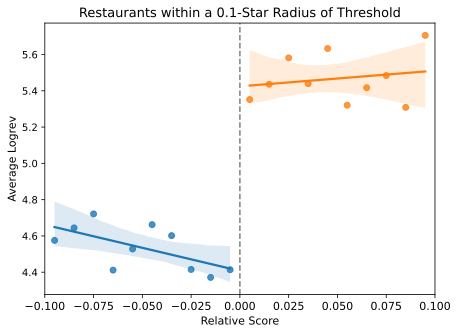

In [21]:
#dummy variable for whether restaurants gain half-star from rounding
df['gain']=np.where(df.score<df.stars, 1, 0) 
#Get relative score to threshold
df['threshold']=np.where(abs(df.stars+0.25-df.score)<abs(df.stars-0.25-df.score), \
                         df.score-(df.stars+0.25), df.score-(df.stars-0.25)) 
#Select scores within a 0.1-star radius of the threshold
close=df[(abs(df.threshold)<=0.1)&(df.threshold!=0)] 

#Split into bins
d_y,d_e,d_ind=bnn(close.threshold, close.logrev,'mean', bins=20, range=[-0.1,0.1])
d_x=(d_e[:-1]+d_e[1:])/2

#Plot the figure
plt.figure(figsize=(7,5))
sns.regplot(x=d_x[:10],y=d_y[:10],truncate=[-0.1,0])
sns.regplot(x=d_x[10:],y=d_y[10:],truncate=[0,0.1])
plt.ylabel('Average Logrev',fontsize='11')
plt.xlabel('Relative Score',fontsize='11')
plt.xlim(-0.1,0.1)
plt.xticks(fontsize=11)
plt.axvline(x=0,color="gray", linestyle="--")
plt.title('Restaurants within a 0.1-Star Radius of Threshold',fontsize='13')
plt.show()